# Comparing different specifications of time-series forest algorithm

In [1]:
import pandas as pd
import os 
import glob
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import wilcoxon, binom_test
from itertools import combinations
from IPython.display import display

%matplotlib inline

### Read in experiment data 

In [2]:
files = glob.glob('*.csv')
print(*files, sep='\n')

tsf_bootstrap-True.csv
tsf_pigs_default.csv
tsf_4_params.csv
tsf_11_params.csv
tsf_pigs_sqrt_500_bootstrap.csv
tsf_9_params.csv
tsf_14_params.csv
tsf_base_estimator__transform__n_intervals.csv
tsf_pigs_tonys.csv
tsf_n_intervals-'random'.csv
tsf_1_params.csv
tsf_pigs_sqrt_500_max-features.csv
tsf_pigs_500_sqrt.csv
tsf_pigs_test.csv
tsf_6_params.csv
tsf_pigs_sqrt_500.csv
tsf_13_params.csv
tsf_pigs_sqrt_500_njobs.csv
tsf_n_intervals-'sqrt'.csv
tsf_n_jobs--1.csv
tsf_16_params.csv
tsf_pigs.csv
tsf_3_params.csv
tsf_pigs_500_random.csv
tsf_pigs_500_sqrt_bootstrap.csv
tsf_15_params.csv
tsf_modular.csv
tsf_pigs_500_njobs-1.csv
tsf_0_params.csv
tsf_max_features-'sqrt'.csv
tsf_5_params.csv
tsf_10_params.csv
tsf_base_estimator__transform__n_intervals-'random'.csv
tsf_time_params.csv
gb.csv
tsf_8_params.csv
tsf_17_params.csv
tsf_2_params.csv
tsf_pigs_modular.csv
tsf_pigs_random_500.csv
tsf_base_estimator__transform__n_intervals-'sqrt'.csv
tsforest_pigs_results.csv
tsf_7_params.csv
tsf_accuracy_para

In [3]:
files = ['tsf_bootstrap-True.csv', "tsf_n_intervals-'random'.csv", 'tsf_pigs_tonys.csv',
         'tsf_n_jobs--1.csv', "tsf_n_intervals-'sqrt'.csv", 'tsf_modular.csv', 
         "tsf_max_features-'sqrt'.csv"]

In [4]:
# read in csv files
dfs = []
for f in files:
    df = pd.read_csv(f)
    # create algorithm specs column from file name  
    df['specs'] = f.split('_')[-1].split('.csv')[0]
    dfs.append(df)

df = pd.concat(dfs)

# convert fit/predict times into minutes
df.fit_time = df.fit_time / 60
df.predict_time = df.predict_time / 60

# rename index column
df.rename(columns={'Unnamed: 0': 'dataset'}, inplace=True) 

# clean up specs descriptions
df['specs'] = df.specs.replace("intervals-'sqrt'", 'default')
df['specs'] = df.specs.replace("intervals-'random'", 'random')
df['specs'] = df.specs.replace("jobs--1", 'njobs')
df['specs'] = df.specs.replace("features-'sqrt'", 'sqrt_features')
df['specs'] = df.specs.replace("bootstrap-True", 'bootstrap')
df.shape

(539, 5)

Add tuning results

In [5]:
arrays = dict()
for file in glob.glob('tsf_tuning/*.txt'):
    res = np.loadtxt(file)
    dataset_name = file.split('_')[-1].replace('.txt', '') 
    arrays[dataset_name] = res

In [6]:
tuned = pd.DataFrame(arrays).T.reset_index()
tuned.columns = ['dataset', 'fit_time', 'predict_time', 'accuracy']
tuned['total_time'] = tuned.fit_time + tuned.predict_time
tuned['specs'] = 'tuned'

In [7]:
df = pd.concat([df, tuned], sort=False)

## Run time comparison

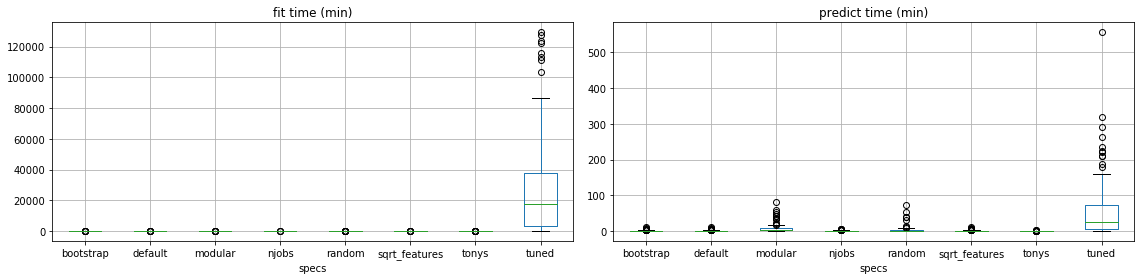

In [8]:
fig, axs = plt.subplots(ncols=2, figsize=(16, 4))
#df.loc[df.fit_time < 50,:].boxplot(by='specs', column='fit_time', ax=axs[0])
df.boxplot(by='specs', column='fit_time', ax=axs[0])

#df.loc[df.predict_time < 25,:].boxplot(by='specs', column='predict_time', ax=axs[2])
df.boxplot(by='specs', column='predict_time', ax=axs[1])

#df.boxplot(by='specs', column='accuracy', ax=axs[2])
plt.suptitle('')
axs[0].set_title('fit time (min)')
axs[1].set_title('predict time (min)')
plt.tight_layout();

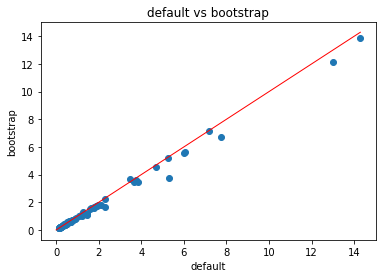

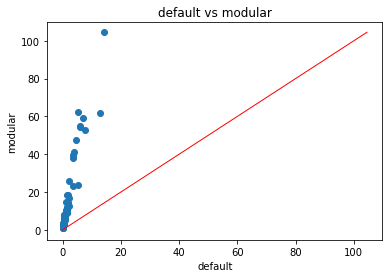

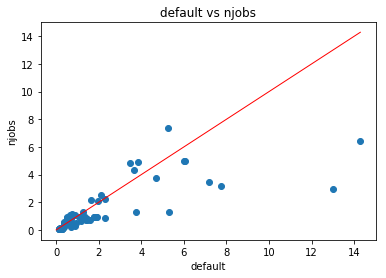

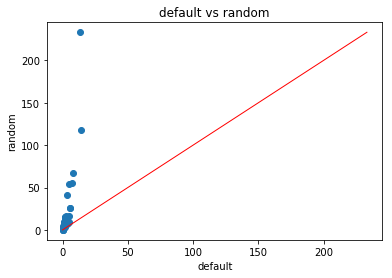

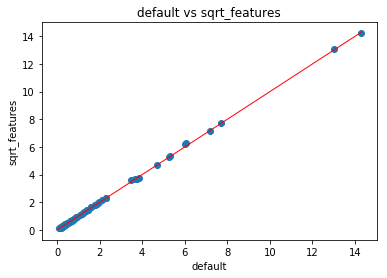

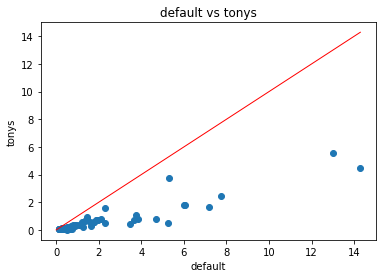

In [9]:
df['total_time'] = df.fit_time + df.predict_time
#for a, b in combinations(np.unique(df.specs), 2):
a = 'default'
for b in ['bootstrap', 'modular', 'njobs', 'random', 'sqrt_features', 'tonys']:
    x = df.loc[df.specs == a, 'total_time']
    y = df.loc[df.specs == b, 'total_time']
    fig, ax = plt.subplots(1)
    ax.scatter(x, y)
    ax.plot([0, np.max([np.max(x), np.max(y)])], [0, np.max([np.max(x), np.max(y)])], 'red', linewidth=1)
    ax.set(xlabel=a, ylabel=b, 
           title=f'{a} vs {b}');

## Accuracy comparison

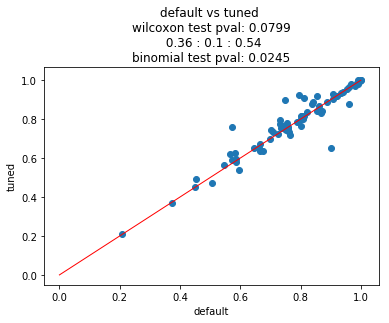

In [11]:
#for a, b in combinations(np.unique(df.specs), 2):
a = 'default'

#for b in ['bootstrap', 'modular', 'njobs', 'random', 'sqrt_features', 'tonys', 'tuned']:
for b in ['tuned']:
    
    data = (df
            .loc[df.specs.isin([a, b]), 
                 ['dataset', 'specs', 'accuracy']]
            .pivot(index='dataset', columns='specs', values='accuracy')
            .dropna())
    
    x = data.loc[:, a]
    y = data.loc[:, b]
    
    p_wil = wilcoxon(x, y).pvalue
    
    x_wins = x > y
    y_wins = y > x
    draw = x == y
    p_bin = binom_test(np.sum(x_wins), n=x.shape[0], p=0.5, alternative='two-sided')
    
    diff = x - y
    fig, ax = plt.subplots(1)
    ax.plot([0, 1], [0, 1], 'red', linewidth=1)
    ax.scatter(x, y)    
    ax.set(xlabel=a, ylabel=b, 
           title=f'{a} vs {b} \nwilcoxon test pval: {np.round(p_wil, 4)}'
                 f'\n {np.round(np.mean(x_wins), 2)} : {np.round(np.mean(draw), 2)} : {np.round(np.mean(y_wins), 2)}'
                 f'\nbinomial test pval: {np.round(p_bin, 4)}');